# Exploring Weight Initialization Schemes in Neural Networks

In this notebook, we experiment with different weight initialization schemes for a simple neural network trained on the Iris dataset. We aim to observe how different initializations affect the training process and convergence.


In [13]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
project_root = os.getenv("PROJECT_ROOT")
if not project_root:
    print("PROJECT_ROOT is not set. Please run set_project_root.py.")
    project_root = '.'

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data  # Features
y = iris.target  # Labels

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=42
)

# Transpose datasets for our neural network implementation
X_train_T = X_train.T  # Shape: (n_features, m_train)
X_val_T = X_val.T      # Shape: (n_features, m_val)
X_test_T = X_test.T    # Shape: (n_features, m_test)

# One-hot encode the labels
n_classes = len(np.unique(y))
y_train_one_hot = np.eye(n_classes)[y_train].T  # Shape: (n_classes, m_train)
y_val_one_hot = np.eye(n_classes)[y_val].T      # Shape: (n_classes, m_val)
y_test_one_hot = np.eye(n_classes)[y_test].T    # Shape: (n_classes, m_test)


In [14]:
import sys
sys.path.append('../src/model/')
from model import NeuralNetwork

class NeuralNetworkWithInit(NeuralNetwork):
    def __init__(self, input_size, hidden_size, output_size, init_hidden='he', init_output='xavier'):
        """Initialize the neural network with given sizes and initialization schemes."""
        self.init_hidden = init_hidden
        self.init_output = init_output
        # Initialize parameters using the overridden method
        self.parameters = self.initialize_parameters(input_size, hidden_size, output_size)

    def initialize_parameters(self, input_size, hidden_size, output_size):
        """Initialize weights and biases based on specified initialization schemes."""
        # Initialize hidden layer parameters
        if self.init_hidden == 'he':
            W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2. / input_size)
        elif self.init_hidden == 'xavier':
            W1 = np.random.randn(hidden_size, input_size) * np.sqrt(1. / input_size)
        elif self.init_hidden == 'normal':
            W1 = np.random.randn(hidden_size, input_size) * 0.01
        elif self.init_hidden == 'zeros':
            W1 = np.zeros((hidden_size, input_size))
        else:
            raise ValueError(f"Unknown initialization scheme '{self.init_hidden}' for hidden layer.")
        
        b1 = np.zeros((hidden_size, 1))
        
        # Initialize output layer parameters
        if self.init_output == 'he':
            W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2. / hidden_size)
        elif self.init_output == 'xavier':
            W2 = np.random.randn(output_size, hidden_size) * np.sqrt(1. / hidden_size)
        elif self.init_output == 'normal':
            W2 = np.random.randn(output_size, hidden_size) * 0.01
        elif self.init_output == 'zeros':
            W2 = np.zeros((output_size, hidden_size))
        else:
            raise ValueError(f"Unknown initialization scheme '{self.init_output}' for output layer.")
        
        b2 = np.zeros((output_size, 1))
        
        parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        return parameters


In [16]:
# Define combinations of initialization schemes to test
initialization_combinations = [
    {'init_hidden': 'he', 'init_output': 'xavier'},
    {'init_hidden': 'he', 'init_output': 'he'},
    {'init_hidden': 'xavier', 'init_output': 'xavier'},
    {'init_hidden': 'normal', 'init_output': 'normal'},
    {'init_hidden': 'zeros', 'init_output': 'zeros'}
]


# Hyperparameters
input_size = X_train_T.shape[0]
hidden_size = 3
output_size = n_classes
learning_rate = 0.01
n_epochs = 1000
batch_size = 16


In [17]:
# Initialize dictionaries to store results
training_losses = {}
validation_losses = {}
training_accuracies = {}
validation_accuracies = {}    

In [18]:
# Function to shuffle data
def shuffle(X, Y):
    m = X.shape[1]
    permutation = np.random.permutation(m)
    return X[:, permutation], Y[:, permutation]

# Function to create mini-batches
def create_batches(X, Y, batch_size):
    m = X.shape[1]
    batches = []
    for i in range(0, m, batch_size):
        X_batch = X[:, i:i+batch_size]
        Y_batch = Y[:, i:i+batch_size]
        batches.append((X_batch, Y_batch))
    return batches

# Initialize dictionaries to store results
training_losses = {}
validation_losses = {}
training_accuracies = {}
validation_accuracies = {}

# Loop over each initialization combination
for init_combo in initialization_combinations:
    init_hidden = init_combo['init_hidden']
    init_output = init_combo['init_output']
    combo_name = f"Hidden: {init_hidden}, Output: {init_output}"
    print(f"\nTraining with {combo_name} initialization...")
    
    # Initialize the network
    nn = NeuralNetworkWithInit(input_size, hidden_size, output_size, init_hidden=init_hidden, init_output=init_output)
    
    # Lists to store loss and accuracy per epoch
    train_loss_per_epoch = []
    val_loss_per_epoch = []
    train_acc_per_epoch = []
    val_acc_per_epoch = []
    
    # Training loop
    for epoch in range(n_epochs):
        # Shuffle training data
        X_train_shuffled, y_train_shuffled = shuffle(X_train_T, y_train_one_hot)
        
        # Create mini-batches
        batches = create_batches(X_train_shuffled, y_train_shuffled, batch_size)
        
        # Loop over mini-batches
        for X_batch, y_batch in batches:
            # Forward propagation
            A2, cache = nn.forward_propagation(X_batch)
            
            # Backpropagation
            gradients = nn.backpropagation(X_batch, y_batch, cache)
            
            # Update parameters
            nn.update_parameters(gradients, learning_rate)
        
        # Compute training loss and accuracy
        A2_train, _ = nn.forward_propagation(X_train_T)
        train_loss = nn.compute_loss(y_train_one_hot, A2_train)
        y_train_pred = nn.predict(X_train_T)
        train_acc = accuracy_score(y_train, y_train_pred)
        
        # Compute validation loss and accuracy
        A2_val, _ = nn.forward_propagation(X_val_T)
        val_loss = nn.compute_loss(y_val_one_hot, A2_val)
        y_val_pred = nn.predict(X_val_T)
        val_acc = accuracy_score(y_val, y_val_pred)
        
        # Store results
        train_loss_per_epoch.append(train_loss)
        val_loss_per_epoch.append(val_loss)
        train_acc_per_epoch.append(train_acc)
        val_acc_per_epoch.append(val_acc)
        
        # Optionally, print progress every 50 epochs
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    # Store results for this initialization combination
    training_losses[combo_name] = train_loss_per_epoch
    validation_losses[combo_name] = val_loss_per_epoch
    training_accuracies[combo_name] = train_acc_per_epoch
    validation_accuracies[combo_name] = val_acc_per_epoch



Training with Hidden: he, Output: xavier initialization...
Epoch 1/1000 - Train Loss: 1.0919, Val Loss: 1.0667, Train Acc: 0.4333, Val Acc: 0.5000
Epoch 50/1000 - Train Loss: 0.7441, Val Loss: 0.7590, Train Acc: 0.7667, Val Acc: 0.6333
Epoch 100/1000 - Train Loss: 0.5684, Val Loss: 0.6057, Train Acc: 0.8444, Val Acc: 0.8333
Epoch 150/1000 - Train Loss: 0.4428, Val Loss: 0.5076, Train Acc: 0.9111, Val Acc: 0.8667
Epoch 200/1000 - Train Loss: 0.3540, Val Loss: 0.4448, Train Acc: 0.9333, Val Acc: 0.8667
Epoch 250/1000 - Train Loss: 0.2901, Val Loss: 0.4037, Train Acc: 0.9778, Val Acc: 0.8667
Epoch 300/1000 - Train Loss: 0.2433, Val Loss: 0.3708, Train Acc: 0.9667, Val Acc: 0.9000
Epoch 350/1000 - Train Loss: 0.2082, Val Loss: 0.3462, Train Acc: 0.9667, Val Acc: 0.9000
Epoch 400/1000 - Train Loss: 0.1814, Val Loss: 0.3259, Train Acc: 0.9667, Val Acc: 0.9000
Epoch 450/1000 - Train Loss: 0.1602, Val Loss: 0.3068, Train Acc: 0.9667, Val Acc: 0.9000
Epoch 500/1000 - Train Loss: 0.1433, Val Lo

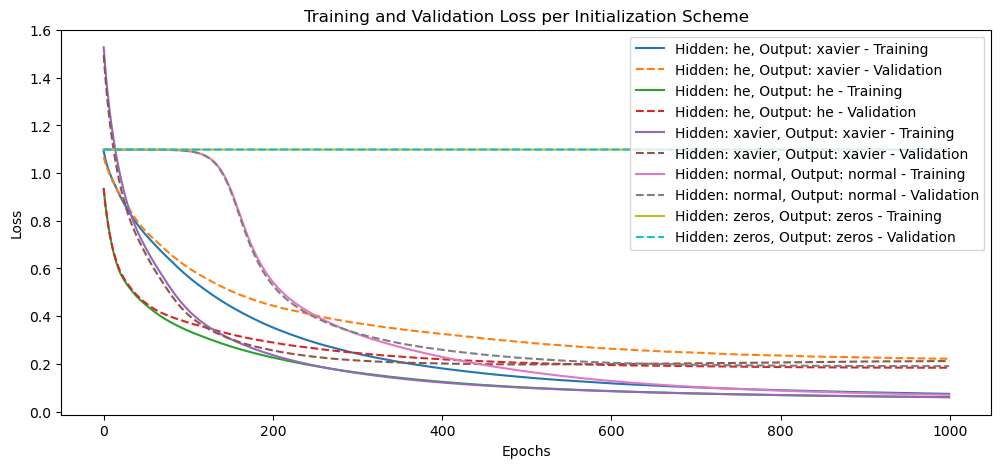

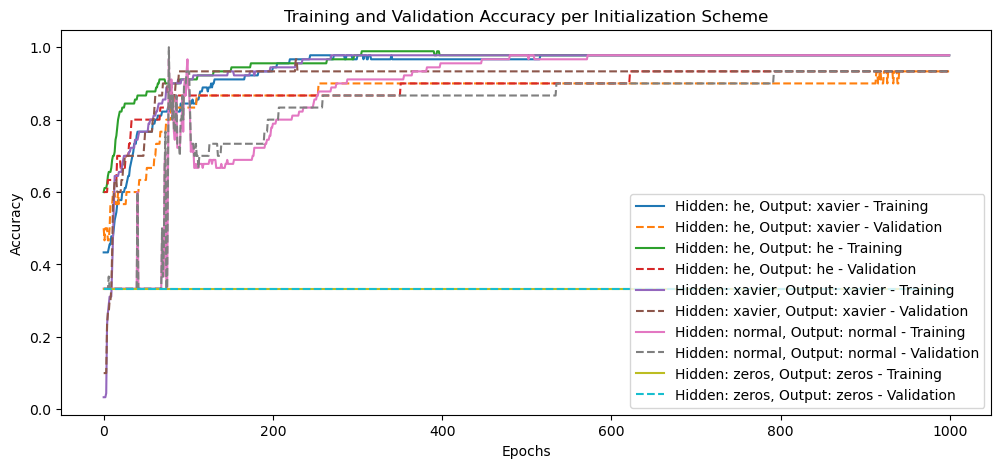

In [19]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
for combo_name in training_losses.keys():
    plt.plot(training_losses[combo_name], label=f'{combo_name} - Training')
    plt.plot(validation_losses[combo_name], linestyle='--', label=f'{combo_name} - Validation')
plt.title('Training and Validation Loss per Initialization Scheme')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
for combo_name in training_accuracies.keys():
    plt.plot(training_accuracies[combo_name], label=f'{combo_name} - Training')
    plt.plot(validation_accuracies[combo_name], linestyle='--', label=f'{combo_name} - Validation')
plt.title('Training and Validation Accuracy per Initialization Scheme')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



**Analysis of Results**

- **He Initialization:**

Designed for ReLU activations, this initialization consistently shows strong convergence and low loss values in both training and validation. It performs particularly well, achieving high accuracy and stable performance across epochs. This initialization scheme allows the network to quickly break symmetry and learn effectively.

- **Xavier Initialization:**

Originally designed for tanh and sigmoid activations, Xavier initialization performs decently with ReLU but not as optimally as He initialization. The training and validation loss reduction is slower, and while accuracy improves, it doesn't match the peak performance seen with He initialization. This suggests that Xavier is a solid choice but may not be the best for ReLU-based networks.

- **Normal Initialization:**

Initializing weights with small random values shows a slower convergence rate compared to He and Xavier. This scheme can lead to vanishing or exploding gradients, which may hinder learning. In this experiment, Normal initialization does improve over time, but the loss reduction is not as efficient, and accuracy gains are more gradual.

 - **Zero Initialization:**

Initializing all weights to zero leads to a failure in learning, as evidenced by stagnant training and validation loss and accuracy. This is expected because zero initialization prevents the model from breaking symmetry, causing it to remain in a poor state throughout training.


